In [3]:
import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from scipy import signal
from skimage import measure
from joblib import Parallel, delayed
#import skfmm

import PointCloudMask as pcm

Mask out background

unique mask colors: 12
1
2
3
4
5
6
7
8
9
10
11
12
new mask colors: 12


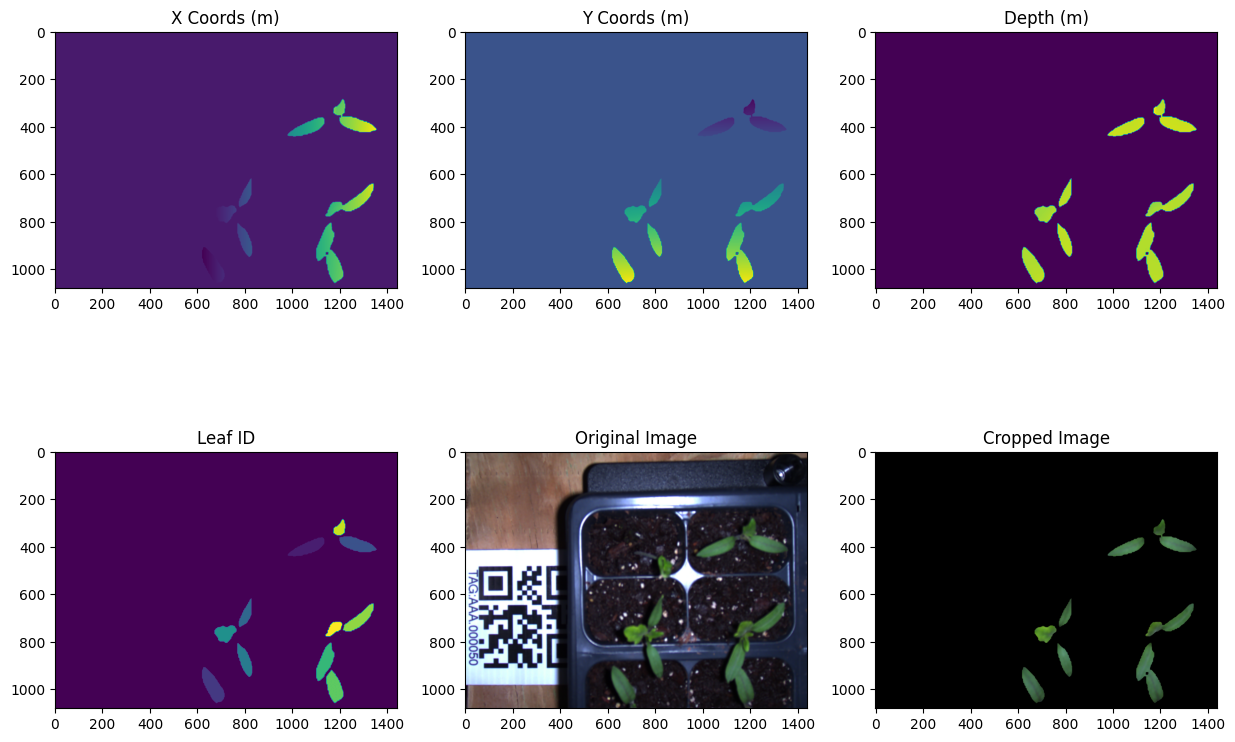

In [4]:
leafs = pcm.apply_depth_mask("Pointclouds/demo_ (1).pcd", 'Images/aggrigated_masks (1).png',
                             "Arrays/depth (1).npy", "Images/left_rect (1).png",  plot=True)

Clean mask

Small clusters with a pixel area of less than 200 are removed.

In [5]:
mask = pcm.clean_mask(leafs)

leafs[:,:,3] = mask

Perform convolution with needle array to erode away leaf edges

In [6]:
depth_image = leafs[:,:,2].astype('float32')
mask_image = leafs[:,:,3].astype('uint8')
kernels = pcm.get_kernels(depth_image, mask_image)
graspable_mask = pcm.compute_graspable_areas(kernels, mask_image)

all kernels:  [38.0, 39.0, 37.0, 39.0, 38.0, 40.0, 39.0, 39.0, 39.0, 38.0, 41.0]


In [7]:
binary_grasp_mask = graspable_mask >=1
leafs[:,:,3] = leafs[:,:,3]*binary_grasp_mask
leafs_ = np.reshape(leafs[:,:,0:3], (1555200, 3))
index = np.argwhere(leafs_ == [0,0,0])
inverse_index = np.nonzero(leafs_[:,2])
leafs__ = np.delete(leafs_, index,0)

In [8]:
processed_pcd = o3d.geometry.PointCloud()
processed_pcd.points = o3d.utility.Vector3dVector(leafs__)

Compute normal vectors

Each leaf's normal vectors are computed, which is then used to estimate how flat each portion of the leaf is.
This is working under the assumption that flat means pointing straight up towards the camera. A more robust implementation
will be needed if flatness is defined relative to each leaf.

In [9]:
pcm.compute_normals(processed_pcd)
sqrt_dist = np.sum((processed_pcd.normals[999])**2, axis=0)
dist = np.sqrt(sqrt_dist)
normal_orientation = np.asarray(processed_pcd.normals)[:,2]
normal_orientation = abs(normal_orientation)
orientation_color = np.zeros((len(normal_orientation), 3))
orientation_color[:,0]=normal_orientation
orientation_color[:,1]=0
orientation_color[:,2]=0
processed_pcd.colors = o3d.utility.Vector3dVector(orientation_color)

Computing Normals!


In [10]:
leaf_flatness = np.zeros((1555200, 1))
j=0
for i in range(len(inverse_index[0])):
    current_index = inverse_index[0][i]
    leaf_flatness[current_index,0] = normal_orientation[j]
    j+=1
    
leaf_flatness = np.reshape(leaf_flatness, (1080,1440,1))
leafs = np.concatenate((leafs, leaf_flatness), axis=2)

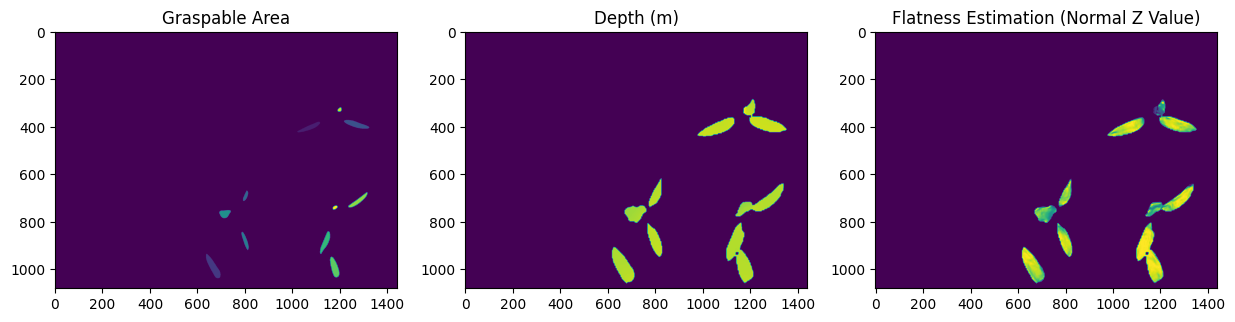

In [11]:
fig, ax = plt.subplot_mosaic([
            ['mask', 'z', 'flatness']
        ], figsize=(15,10))

ax['z'].imshow(leafs[:, :, 2])
ax['z'].set_title("Depth (m)")
ax['mask'].imshow(leafs[:, :, 3])
ax['mask'].set_title("Graspable Area")
ax['flatness'].imshow(leafs[:,:,4])
ax['flatness'].set_title("Flatness Estimation (Normal Z Value)")
plt.show()

Combine graspable area with flatness data to compute best part to grasp on each leaf

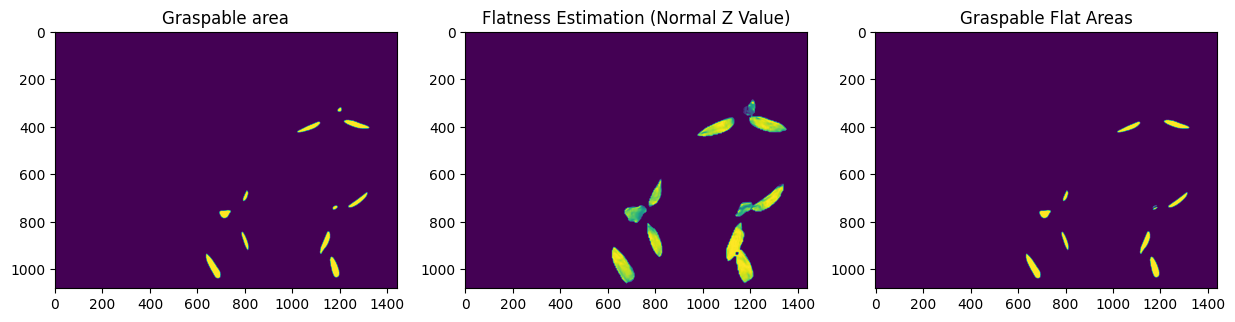

In [12]:
alpha = 0.2
graspable_area = binary_grasp_mask
smooth_section = leafs[:,:,4]
leaf_selection_a = alpha*smooth_section+(1-alpha)*graspable_area


leaf_selection_ab = np.where(leaf_selection_a, leaf_selection_a > np.amax(leaf_selection_a)*.9,
                                      0)


fig, ax = plt.subplot_mosaic([
            ['grasp', 'flatness', 'combined']
        ], figsize=(15,10))

ax['grasp'].imshow(graspable_area)
ax['grasp'].set_title("Graspable area")
ax['combined'].imshow(leaf_selection_ab)
ax['combined'].set_title("Graspable Flat Areas")
ax['flatness'].imshow(leafs[:,:,4])
ax['flatness'].set_title("Flatness Estimation (Normal Z Value)")
plt.show()

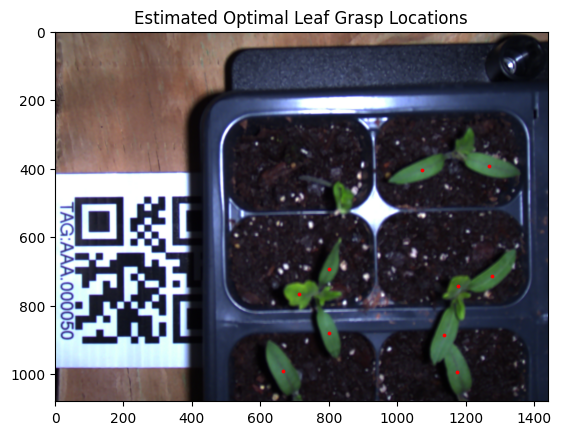

In [13]:
viable_leaf_regions = leaf_selection_ab*leafs[:,:,3]
centroids = pcm.get_centroids(viable_leaf_regions.astype('uint8'))

for i, _ in enumerate(centroids):
    plt.scatter(centroids[i][0], centroids[i][1],s=3,c='r')

left_image = Image.open("Images/left_rect (1).png")
left_array = np.asarray(left_image)[:, :, 0:3]
plt.imshow(left_array)
plt.title("Estimated Optimal Leaf Grasp Locations")
plt.show()